# Prerequisites

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

from sklearn.model_selection  import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
import time

# DeepSpeed ZeRO-3
# import deepspeed
# from deepspeed.accelerator import get_accelerator

/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [4]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 23.25750732421875, Global(GB): 23.64971923828125, Free(%): 0.9834157898404292


# Data process and tokenizer

In [5]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    "openai-community/gpt2",
)
tokenizer.pad_token = tokenizer.eos_token

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


In [6]:
tokenizer

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

# Dataset iterator

In [21]:
test_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
test_df = test_df[['E1','Text']]
#Convert E1 column values to integers
test_df['E1'] = test_df['E1'].astype(int)
test_df.head()

,E1,Text
0,1,Massive Data Broadcast shall immediately send ...
1,1,Massive Data Broadcast shall place a copied Re...
2,1,Massive Data Broadcast shall place a copied Ma...
3,1,Massive Data Broadcast shall send the current ...
4,1,Massive Data Broadcast shall send the current ...


## Ensemble models

In [22]:
BATCH_SIZE = 64

class GPT2AverageEnsemble():
    def __init__(self, models = []):
        self.models = models
    
    def forward(self, input_ids, attention_mask):
        ensembled_logits = torch.zeros((len(input_ids), 2)).to(device)
        for model in self.models:
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            ensembled_logits = ensembled_logits + output.logits
                
        ensembled_logits = ensembled_logits / float(len(self.models)) # Calculate the average

        return ensembled_logits
        

In [23]:
model1 = torch.load("./models/gpt2/2024-06-01_gpt2.pt",
                    map_location=device
                   )
model1.config.pad_token_id = tokenizer.pad_token_id
model1.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Sequential(
    (0): Linear(in_features=768, out_features=2560, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=2560, out_featur

In [24]:
model2 = torch.load("./models/gpt2/2024-05-29_gpt2.pt",
                    map_location=device
                   )
model2.config.pad_token_id = tokenizer.pad_token_id
model2.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Sequential(
    (0): Linear(in_features=768, out_features=2560, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=2560, out_featur

In [55]:
model3 = torch.load("./models/gpt2/2024-06-01_gpt2_3.pt",
                    map_location=device
                   )
model3.config.pad_token_id = tokenizer.pad_token_id
model3.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Sequential(
    (0): Linear(in_features=768, out_features=2560, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=2560, out_featur

In [56]:
ensemble = GPT2AverageEnsemble([
    model1, 
    model2,
    model3
])
ensemble

Checking the results of the test dataset…



In [57]:
tokenizer

GPT2TokenizerFast(name_or_path='openai-community/gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [58]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True, return_tensors='pt')
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)
    
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [59]:
from torchtext.data.functional import to_map_style_dataset

test_iter = iter(list(test_df.itertuples(index=False, name=None)))
test_dataset = to_map_style_dataset(test_iter)
    
test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_batch)

In [60]:
ensemble.models[0].device

device(type='cuda', index=0)

In [61]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            data.input_ids = data.input_ids.to(device)
            data.attention_mask = data.attention_mask.to(device)
            outputs = ensemble.forward(input_ids=data.input_ids, attention_mask=data.attention_mask)
            
            predicted_label = outputs
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

/tmp/ipykernel_51637/67003502.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
/tmp/ipykernel_51637/67003502.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)


              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88       997
         1.0       0.94      0.95      0.94      2127

    accuracy                           0.92      3124
   macro avg       0.91      0.91      0.91      3124
weighted avg       0.92      0.92      0.92      3124



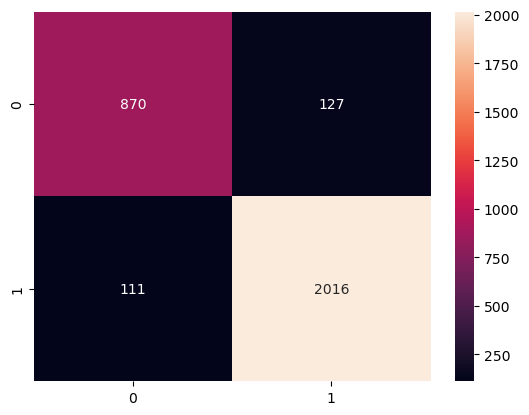

In [62]:
plot_confusion_matrix(ensemble, test_dataloader)

### ROC Curves

In [63]:
from sklearn.metrics import roc_curve, auc

In [64]:
# Calc prediction to evaluate against ground truth
y_test = np.asarray([])
y_predict = np.asarray([])

with torch.no_grad():
    for idx, (data, label) in enumerate(test_dataloader):
        outputs = ensemble.forward(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs

        y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
        y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

/tmp/ipykernel_51637/67003502.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
/tmp/ipykernel_51637/67003502.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)


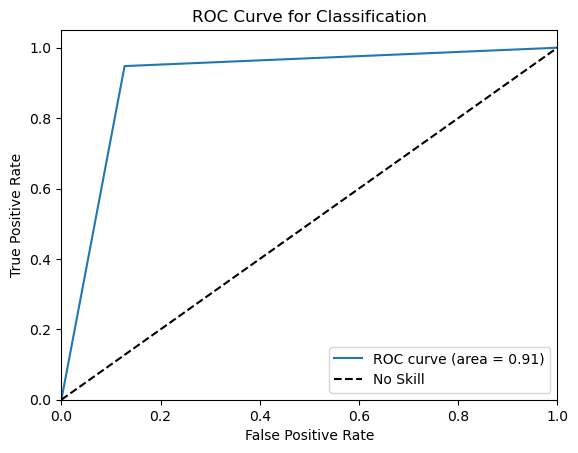

In [65]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification')
plt.legend()
plt.show()